In [9]:
import matplotlib
print(matplotlib.get_cachedir())

/Users/tk/.matplotlib


--- 4. กำลังสร้างโมเดล Anomaly Detection จากไฟล์: ../data/processed/daily_rainfall_2024_processed.csv ---
สร้าง Features เพิ่มเติม (ฝนสะสม, ค่าเฉลี่ยเคลื่อนที่) เรียบร้อยแล้ว
ตรวจจับความผิดปกติเรียบร้อยแล้ว

ตรวจพบวันที่อาจมีความผิดปกติทั้งหมด: 19 วัน

**ตัวอย่างวันที่ตรวจพบความผิดปกติ (เรียงตามคะแนน):**
            avg_rainfall_mm  rainfall_ma_7  rainfall_sum_3  anomaly_score  \
date                                                                        
2024-10-19        53.303922      13.988796       65.029412      -0.134289   
2024-05-31        47.509804      12.046218       51.784314      -0.093409   
2024-05-24        26.568627      16.791317       79.794118      -0.089782   
2024-03-21        39.176471       6.082633       39.196078      -0.089722   
2024-10-24        18.882353      20.252101       74.333333      -0.088871   

            is_anomaly  
date                    
2024-10-19          -1  
2024-05-31          -1  
2024-05-24          -1  
2024-03-21          -1  
2024

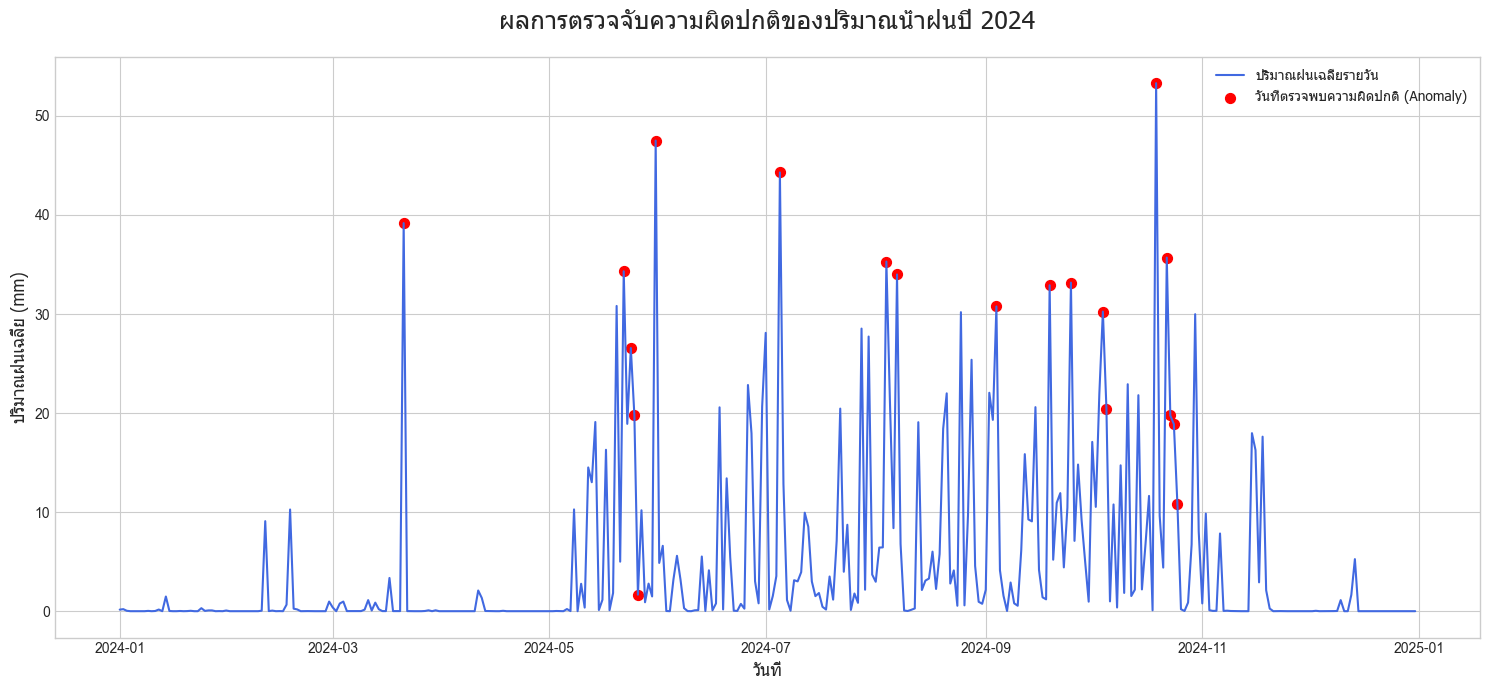

✅ บันทึกผลลัพธ์การตรวจจับความผิดปกติเรียบร้อยแล้วที่ '../data/processed/daily_rainfall_anomaly_results.csv'


In [ ]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm # เพิ่ม import นี้
import os

try:
    font_path = '/System/Library/Fonts/Supplemental/Tahoma.ttf' # สำหรับ macOS
    font_prop = fm.FontProperties(fname=font_path)
    if not os.path.exists(font_path):
        font_path = 'C:/Windows/Fonts/tahoma.ttf' # สำหรับ Windows
        font_prop = fm.FontProperties(fname=font_path)
except Exception:
    print("ไม่พบฟอนต์ Tahoma ในที่อยู่มาตรฐาน, กราฟอาจยังเป็นสี่เหลี่ยม")
    font_prop = fm.FontProperties(family='sans-serif') # ใช้ฟอนต์สำรอง
# --------------------------------------------------

# --- ตั้งค่า Path ---
PROCESSED_DIR = '../data/processed'
RAINFALL_PATH = os.path.join(PROCESSED_DIR, 'daily_rainfall_2024_processed.csv')
OUTPUT_PATH = os.path.join(PROCESSED_DIR, 'daily_rainfall_anomaly_results.csv')

def run_anomaly_detection(data_path=RAINFALL_PATH):
    """
    ฟังก์ชันสำหรับตรวจจับความผิดปกติของข้อมูลปริมาณน้ำฝน
    """
    print(f"--- 4. กำลังสร้างโมเดล Anomaly Detection จากไฟล์: {data_path} ---")

    try:
        df = pd.read_csv(data_path, parse_dates=['date'], index_col='date')
    except FileNotFoundError:
        print(f"❌ ไม่พบไฟล์ '{data_path}'! กรุณารันสคริปต์เตรียมข้อมูลก่อน")
        return

    # (ส่วนประมวลผลข้อมูลเหมือนเดิม)
    df['rainfall_ma_7'] = df['avg_rainfall_mm'].rolling(window=7, min_periods=1).mean()
    df['rainfall_sum_3'] = df['avg_rainfall_mm'].rolling(window=3, min_periods=1).sum()
    print("สร้าง Features เพิ่มเติม (ฝนสะสม, ค่าเฉลี่ยเคลื่อนที่) เรียบร้อยแล้ว")
    features_to_use = ['avg_rainfall_mm', 'rainfall_ma_7', 'rainfall_sum_3']
    X = df[features_to_use]
    model = IsolationForest(contamination=0.05, random_state=42)
    model.fit(X)
    df['anomaly_score'] = model.decision_function(X)
    df['is_anomaly'] = model.predict(X)
    print("ตรวจจับความผิดปกติเรียบร้อยแล้ว")
    anomalies = df[df['is_anomaly'] == -1]
    print(f"\nตรวจพบวันที่อาจมีความผิดปกติทั้งหมด: {len(anomalies)} วัน")
    print("\n**ตัวอย่างวันที่ตรวจพบความผิดปกติ (เรียงตามคะแนน):**")
    print(anomalies.sort_values('anomaly_score').head())

    # --- ✨ ส่วนที่ 2: แก้ไขการวาดกราฟให้ใช้ font_prop ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(15, 7))
    plt.plot(df.index, df['avg_rainfall_mm'], color='royalblue', label='ปริมาณฝนเฉลี่ยรายวัน')
    plt.scatter(anomalies.index, anomalies['avg_rainfall_mm'], color='red', s=50, label='วันที่ตรวจพบความผิดปกติ (Anomaly)')
    
    # เพิ่ม fontproperties=font_prop ในทุกส่วนที่เป็นภาษาไทย
    plt.title('ผลการตรวจจับความผิดปกติของปริมาณน้ำฝนปี 2024', fontproperties=font_prop, fontsize=18, pad=20)
    plt.xlabel('วันที่', fontproperties=font_prop, fontsize=12)
    plt.ylabel('ปริมาณฝนเฉลี่ย (mm)', fontproperties=font_prop, fontsize=12)
    
    # สำหรับ legend ต้องทำแบบนี้
    plt.legend(prop=font_prop)

    plt.tight_layout()
    plt.show()
    # ---------------------------------------------------------

    # --- บันทึกผลลัพธ์ ---
    df.to_csv(OUTPUT_PATH)
    print(f"✅ บันทึกผลลัพธ์การตรวจจับความผิดปกติเรียบร้อยแล้วที่ '{OUTPUT_PATH}'")

# --- รันโค้ด ---
if __name__ == '__main__':
    run_anomaly_detection()

--- 2. กำลังสร้างโมเดล Clustering จากไฟล์: ../data/processed/district_risk_profile_processed.csv ---
กำลังตรวจสอบและเติมค่าว่าง (NaN) ใน Features ที่จะใช้...
  - เติมค่า NaN ในคอลัมน์ 'AREA' ด้วยค่าเฉลี่ย: 32059725.42
ปรับสเกลข้อมูล (Standardization) เรียบร้อยแล้ว
จัดกลุ่มเขตทั้งหมดออกเป็น 4 กลุ่มเรียบร้อยแล้ว

**สรุปจำนวนเขตในแต่ละกลุ่ม:**
Cluster
0     7
1    14
2    28
3     1
Name: count, dtype: int64


/var/folders/89/hx457xt54dl3cdz1fssyz4tr0000gn/T/ipykernel_59265/1533311486.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=df, palette='viridis', order=sorted(df['Cluster'].unique()))


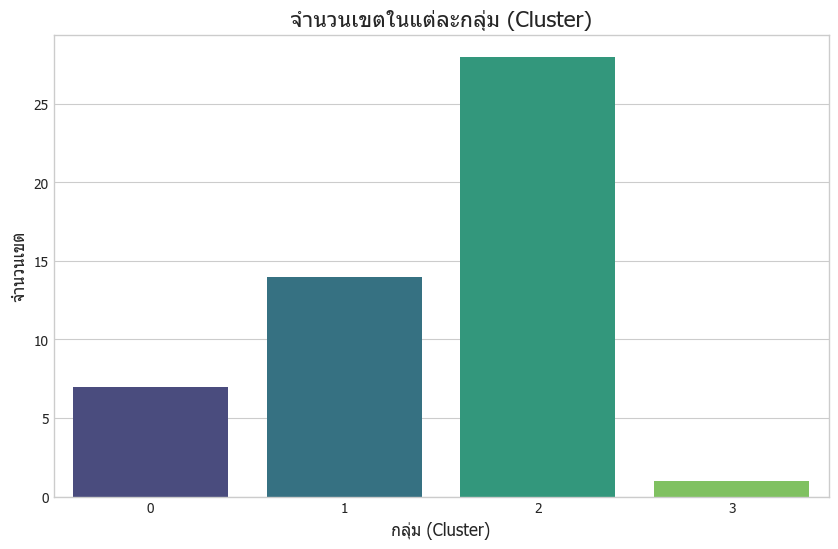


**ค่าเฉลี่ยของแต่ละ Feature ในแต่ละกลุ่ม (เพื่อตีความหมาย):**
         คะแนนรวม  จำนวนจุดเสี่ยง  จำนวนจุดเฝ้าระวังน้ำท่วม          AREA
Cluster                                                                  
0           19.00            1.86                     12.29  1.799986e+07
1           18.96            6.64                      3.36  5.043587e+07
2           35.73            1.14                      2.32  1.894417e+07
3           23.00           15.00                      1.00  2.404482e+08

**รายชื่อเขตในแต่ละกลุ่ม:**

--- กลุ่มที่ 0 ---
['คลองเตย', 'บางนา', 'ดุสิต', 'สาทร', 'วัฒนา', 'บางเขน', 'ลาดพร้าว']

--- กลุ่มที่ 1 ---
['ภาษีเจริญ', 'สวนหลวง', 'ลาดกระบัง', 'บางซื่อ', 'สายไหม', 'บึงกุ่ม', 'ประเวศ', 'จตุจักร', 'บางกะปิ', 'ทุ่งครุ', 'วังทองหลาง', 'บางขุนเทียน', 'คลองสามวา', 'บางแค']

--- กลุ่มที่ 2 ---
['ป้อมปราบศัตรูพ่าย', 'บางกอกน้อย', 'บางรัก', 'ปทุมวัน', 'พระนคร', 'คลองสาน', 'จอมทอง', 'ดอนเมือง', 'ยานนาวา', 'ราษฎร์บูรณะ', 'ธนบุรี', 'พญาไท', 'บางพลัด', 'บางกอกใหญ่', '

In [17]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- 🎨 ตั้งค่าฟอนต์ภาษาไทย ---
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Tahoma'] # ใช้ Tahoma เป็นฟอนต์เริ่มต้นที่มักจะมีในเครื่อง
# ------------------------------------

# --- ตั้งค่า Path ---
PROCESSED_DIR = '../data/processed'
RISK_PROFILE_PATH = os.path.join(PROCESSED_DIR, 'district_risk_profile_processed.csv')
OUTPUT_PATH = os.path.join(PROCESSED_DIR, 'district_cluster_results.csv')

def run_clustering_analysis(data_path=RISK_PROFILE_PATH, n_clusters=4):
    """
    ฟังก์ชันสำหรับทำ Clustering เพื่อจัดกลุ่มเขตตามความเสี่ยง
    """
    print(f"--- 2. กำลังสร้างโมเดล Clustering จากไฟล์: {data_path} ---")
    
    try:
        df = pd.read_csv(data_path)
        df.dropna(subset=['เขต'], inplace=True) # <-- ✨ เพิ่มบรรทัดนี้
    except FileNotFoundError:
        print(f"❌ ไม่พบไฟล์ '{data_path}'! กรุณารันสคริปต์เตรียมข้อมูล (01) ก่อน")
        return

    features_to_use = [
        'คะแนนรวม',
        'จำนวนจุดเสี่ยง',
        'จำนวนจุดเฝ้าระวังน้ำท่วม',
        'AREA'
    ]
    
    # --- ✨ ส่วนที่แก้ไข: วนลูปเพื่อตรวจสอบและเติมค่า NaN ในทุกคอลัมน์ ---
    print("กำลังตรวจสอบและเติมค่าว่าง (NaN) ใน Features ที่จะใช้...")
    for col in features_to_use:
        if df[col].isnull().any():
            mean_val = df[col].mean()
            # แก้ไขตามคำแนะนำ FutureWarning เพื่อให้โค้ดทันสมัยขึ้น
            df[col] = df[col].fillna(mean_val)
            print(f"  - เติมค่า NaN ในคอลัมน์ '{col}' ด้วยค่าเฉลี่ย: {mean_val:.2f}")

    X = df[features_to_use]

    # --- 2. การปรับสเกลข้อมูล (Feature Scaling) ---
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print("ปรับสเกลข้อมูล (Standardization) เรียบร้อยแล้ว")

    # --- 3. สร้างและฝึกโมเดล K-Means ---
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X_scaled) # ครั้งนี้จะไม่มี Error NaN แล้ว

    # --- 4. เพิ่มผลลัพธ์การจัดกลุ่มกลับเข้าไปในตารางเดิม ---
    df['Cluster'] = kmeans.labels_
    print(f"จัดกลุ่มเขตทั้งหมดออกเป็น {n_clusters} กลุ่มเรียบร้อยแล้ว")

    # --- 5. วิเคราะห์และแสดงผลลัพธ์ ---
    print("\n**สรุปจำนวนเขตในแต่ละกลุ่ม:**")
    print(df['Cluster'].value_counts().sort_index())

    plt.figure(figsize=(10, 6))
    sns.countplot(x='Cluster', data=df, palette='viridis', order=sorted(df['Cluster'].unique()))
    plt.title('จำนวนเขตในแต่ละกลุ่ม (Cluster)', fontsize=16)
    plt.xlabel('กลุ่ม (Cluster)', fontsize=12)
    plt.ylabel('จำนวนเขต', fontsize=12)
    plt.show()

    cluster_summary = df.groupby('Cluster')[features_to_use].mean().round(2)
    print("\n**ค่าเฉลี่ยของแต่ละ Feature ในแต่ละกลุ่ม (เพื่อตีความหมาย):**")
    print(cluster_summary)
    
    print("\n**รายชื่อเขตในแต่ละกลุ่ม:**")
    for i in sorted(df['Cluster'].unique()):
        print(f"\n--- กลุ่มที่ {i} ---")
        print(df[df['Cluster'] == i]['เขต'].tolist())

    # --- 6. บันทึกผลลัพธ์ ---
    df.to_csv(OUTPUT_PATH, index=False, encoding='utf-8-sig')
    print(f"\n✅ บันทึกผลลัพธ์การจัดกลุ่มเรียบร้อยแล้วที่ '{OUTPUT_PATH}'")


# --- รันโค้ด ---
if __name__ == '__main__':
    # เราจะลองแบ่งเขตออกเป็น 4 กลุ่ม (คุณสามารถปรับเปลี่ยนตัวเลขนี้ได้)
    run_clustering_analysis(n_clusters=4)

In [ ]:
import pandas as pd
import os

# --- 1. Setup and Load Data ---
PROCESSED_DIR = '../data/processed'
CLUSTER_RESULTS_PATH = os.path.join(PROCESSED_DIR, 'district_cluster_results.csv')
ANOMALY_RESULTS_PATH = os.path.join(PROCESSED_DIR, 'daily_rainfall_anomaly_results.csv')

try:
    df_clusters = pd.read_csv(CLUSTER_RESULTS_PATH)
    df_anomalies = pd.read_csv(ANOMALY_RESULTS_PATH, parse_dates=['date'])
except FileNotFoundError:
    print("❌ Cannot find processed files! Please run notebooks 02 and 03 first.")
    # Exit if files are not found
    exit()

print("✅ Successfully loaded cluster and anomaly results.")


# --- 2. Define Risk Profiles for Each Cluster ---
# Based on our previous analysis of the clusters.
# We'll assign a human-readable risk level to each cluster number.
# IMPORTANT: Adjust the cluster numbers if your results are different.
cluster_risk_mapping = {
    3: "🌋 เขตเดี่ยวพิเศษ (Special High-Risk)", # หนองจอก
    2: "🧡 เขตเมืองชั้นใน (High-Risk Core)",
    0: "💛 เขตเฝ้าระวังพิเศษ (Watchlist)",
    1: "💚 เขตขยายตัว (Mid-Risk Suburbs)"
}
df_clusters['Risk_Level'] = df_clusters['Cluster'].map(cluster_risk_mapping)

print("\n--- Risk Profiles Defined ---")
print(df_clusters[['Cluster', 'Risk_Level']].drop_duplicates().sort_values('Cluster'))


# --- 3. Create the Alerting Function ---
def generate_daily_alert(target_date):
    """
    Checks the rainfall anomaly for a given date and generates a targeted alert.
    """
    
    target_date = pd.to_datetime(target_date)
    
    # Find the anomaly data for the target date
    daily_data = df_anomalies[df_anomalies['date'] == target_date]
    
    if daily_data.empty:
        return f"No rainfall data found for {target_date.date()}."
        
    is_anomaly = daily_data['is_anomaly'].iloc[0]
    rainfall = daily_data['avg_rainfall_mm'].iloc[0]
    
    print("\n" + "="*50)
    print(f"📅 Generating Alert for: {target_date.date()}")
    print(f"🌧️ Average Rainfall: {rainfall:.2f} mm")
    print("="*50)

    # --- This is the core logic of the Alert Matrix ---
    if is_anomaly == -1: # Anomaly detected!
        print("🚨 THREAT LEVEL: HIGH - Anomaly Detected!")
        print("Recommended Actions: Activate high-level monitoring and preparedness protocols.\n")
        
        # Alert the highest risk groups first
        print("--- 🌋 SPECIAL HIGH-RISK ALERT ---")
        special_risk_districts = df_clusters[df_clusters['Risk_Level'] == cluster_risk_mapping[3]]['เขต'].tolist()
        print(f"Districts to monitor with highest priority: {special_risk_districts}")
        
        print("\n--- 🧡 HIGH-RISK CORE ALERT ---")
        high_risk_districts = df_clusters[df_clusters['Risk_Level'] == cluster_risk_mapping[2]]['เขต'].tolist()
        print(f"Districts to prepare for potential impacts: {high_risk_districts}")
        
    else: # Normal day
        print("✅ THREAT LEVEL: LOW - Normal Rainfall Pattern")
        print("No immediate action required. Continue standard monitoring.")

# --- 4. Simulate and Run ---
# Let's test the function on a few dates.

# Test Case 1: A day that the model identified as an anomaly
# (Find a date with is_anomaly == -1 from your 'daily_rainfall_anomaly_results.csv')
anomalous_date = df_anomalies[df_anomalies['is_anomaly'] == -1]['date'].iloc[0]
generate_daily_alert(anomalous_date)

# Test Case 2: A normal day (e.g., the first day of the year)
generate_daily_alert('2024-01-01')

✅ Successfully loaded cluster and anomaly results.

--- Risk Profiles Defined ---
    Cluster                            Risk_Level
25        0       💛 เขตเฝ้าระวังพิเศษ (Watchlist)
20        1       💚 เขตขยายตัว (Mid-Risk Suburbs)
0         2     🧡 เขตเมืองชั้นใน (High-Risk Core)
34        3  🌋 เขตเดี่ยวพิเศษ (Special High-Risk)

📅 Generating Alert for: 2024-03-21
🌧️ Average Rainfall: 39.18 mm
🚨 THREAT LEVEL: HIGH - Anomaly Detected!
Recommended Actions: Activate high-level monitoring and preparedness protocols.

--- 🌋 SPECIAL HIGH-RISK ALERT ---
Districts to monitor with highest priority: ['หนองจอก']

--- 🧡 HIGH-RISK CORE ALERT ---
Districts to prepare for potential impacts: ['ป้อมปราบศัตรูพ่าย', 'บางกอกน้อย', 'บางรัก', 'ปทุมวัน', 'พระนคร', 'คลองสาน', 'จอมทอง', 'ดอนเมือง', 'ยานนาวา', 'ราษฎร์บูรณะ', 'ธนบุรี', 'พญาไท', 'บางพลัด', 'บางกอกใหญ่', 'สะพานสูง', 'พระโขนง', 'หนองแขม', 'ดินแดง', 'ตลิ่งชัน', 'ทวีวัฒนา', 'มีนบุรี', 'ห้วยขวาง', 'คันนายาว', 'สัมพันธวงศ์', 'หลักสี่', 'บางคอแหลม', 'บ

✅ โหลดไฟล์ข้อมูลที่ประมวลผลแล้วสำเร็จ!

--- 🔬 กำลังสร้างกราฟวิเคราะห์โปรไฟล์ของกลุ่มเขต ---


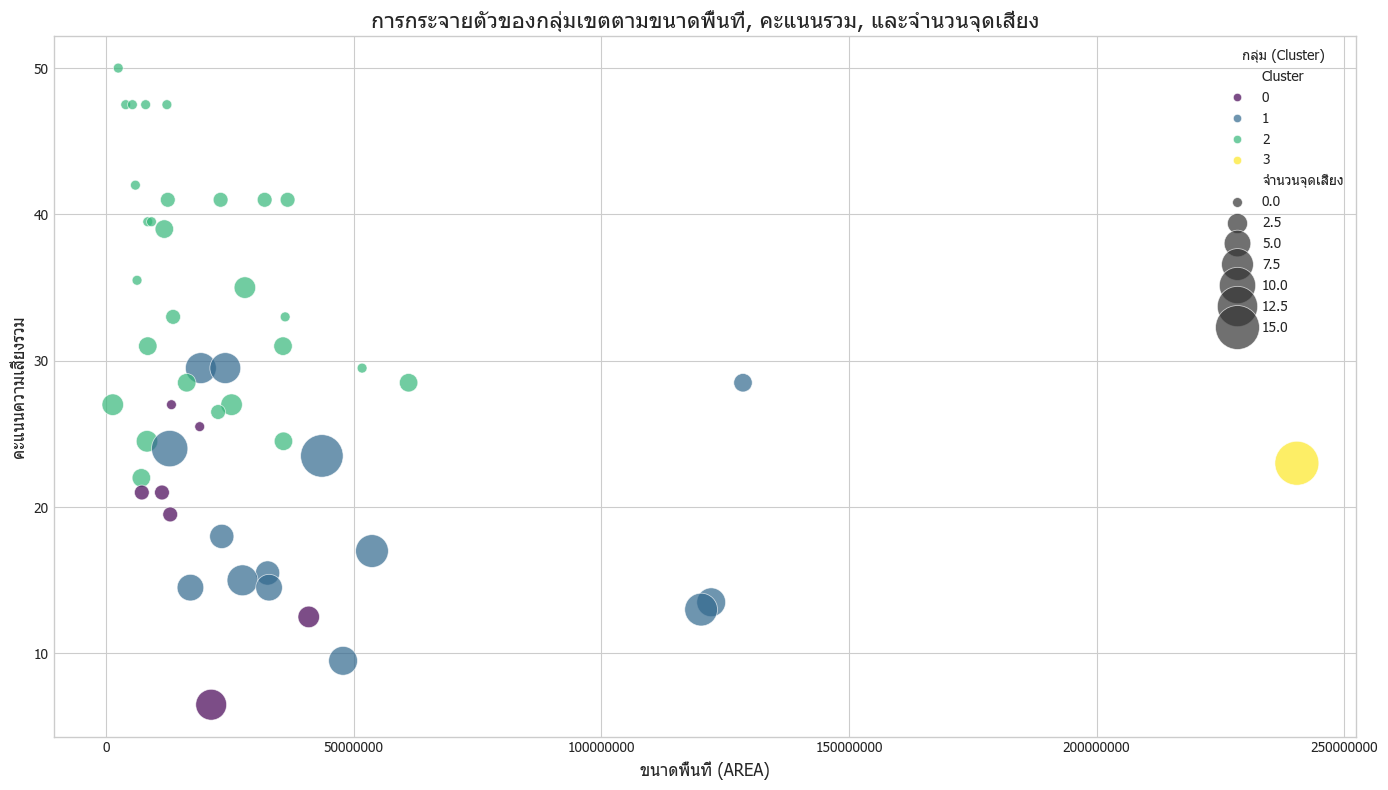

/var/folders/89/hx457xt54dl3cdz1fssyz4tr0000gn/T/ipykernel_59265/1031859232.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[i], data=df_clusters, x='Cluster', y=feature, palette='viridis')
/var/folders/89/hx457xt54dl3cdz1fssyz4tr0000gn/T/ipykernel_59265/1031859232.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[i], data=df_clusters, x='Cluster', y=feature, palette='viridis')
/var/folders/89/hx457xt54dl3cdz1fssyz4tr0000gn/T/ipykernel_59265/1031859232.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[i], da

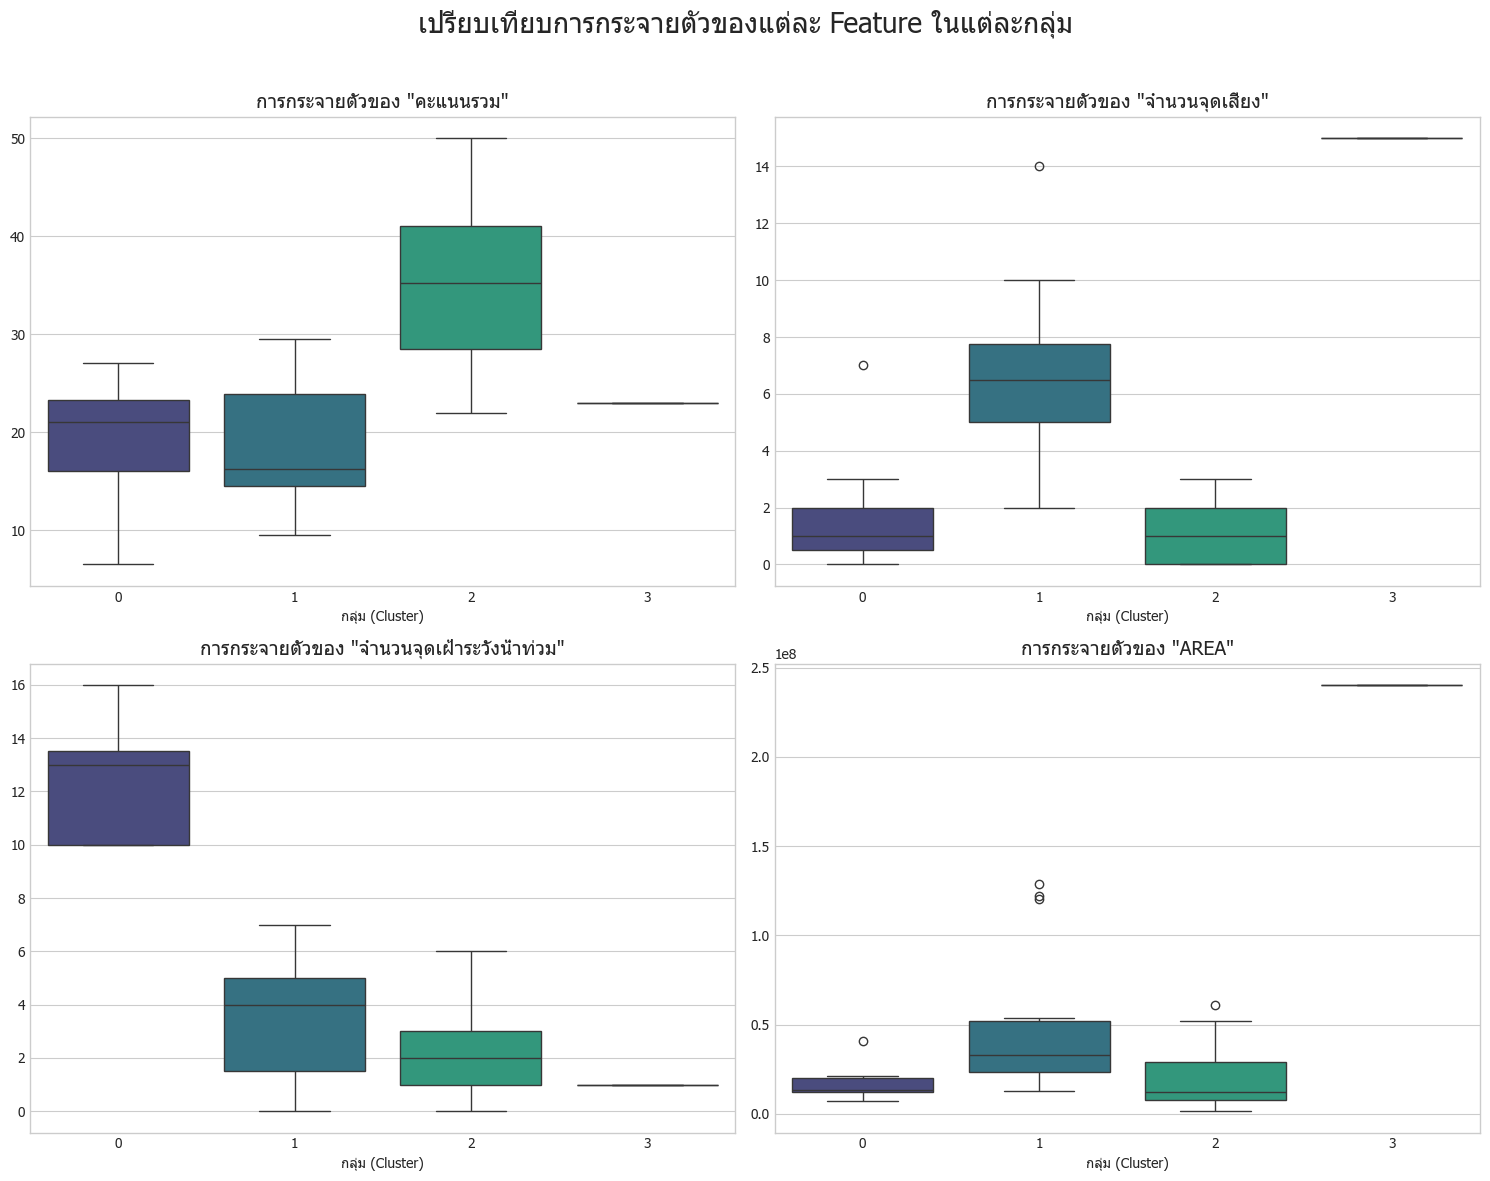

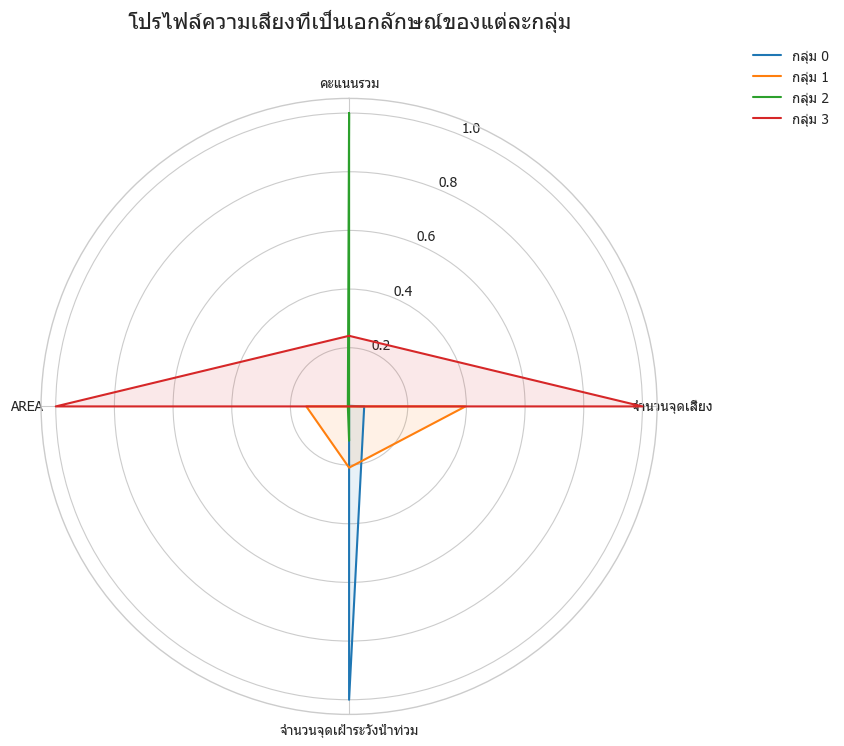


--- 🌧️ กำลังสร้างกราฟวิเคราะห์รูปแบบของฝน ---


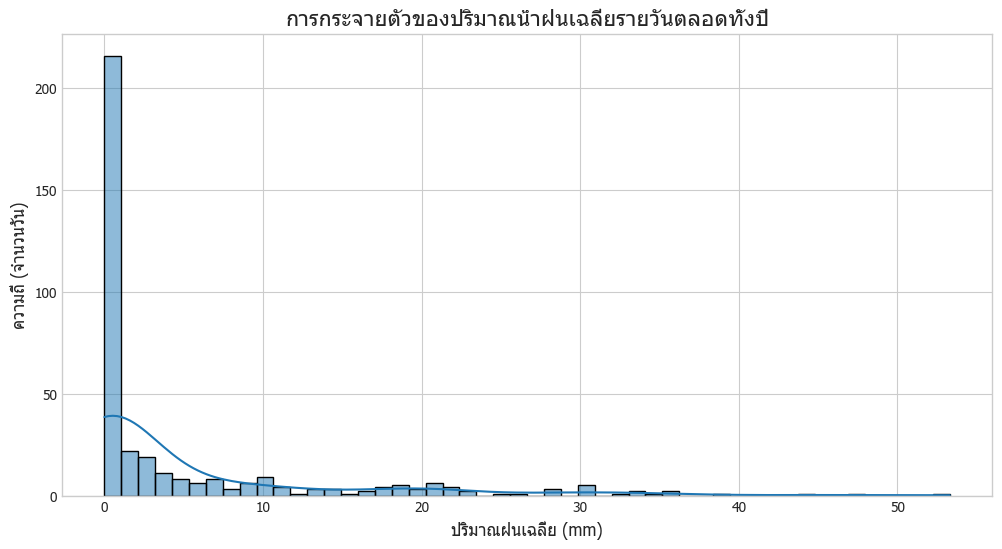

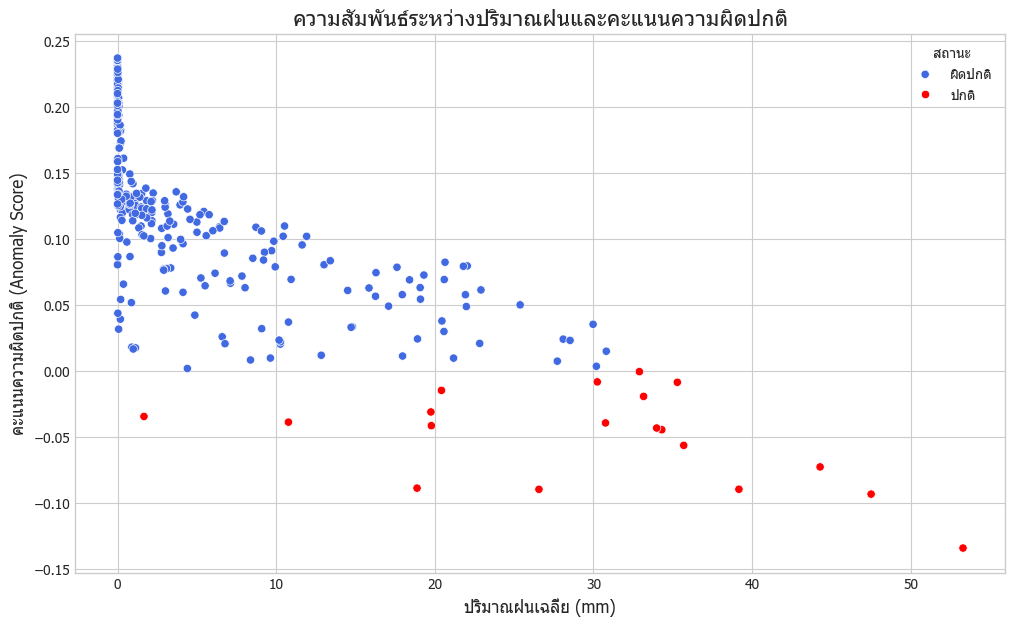


🎉 สร้างกราฟทั้งหมดเสร็จสิ้น!


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# --- 🎨 1. ตั้งค่าพื้นฐานและฟอนต์ภาษาไทย ---
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Tahoma'] 

# --- 📂 2. ตั้งค่า Path และโหลดข้อมูล ---
PROCESSED_DIR = '../data/processed'
CLUSTER_FILE = os.path.join(PROCESSED_DIR, 'district_cluster_results.csv')
ANOMALY_FILE = os.path.join(PROCESSED_DIR, 'daily_rainfall_anomaly_results.csv')

try:
    df_clusters = pd.read_csv(CLUSTER_FILE)
    df_anomalies = pd.read_csv(ANOMALY_FILE, parse_dates=['date'])
    print("✅ โหลดไฟล์ข้อมูลที่ประมวลผลแล้วสำเร็จ!")
except FileNotFoundError:
    print("❌ ไม่พบไฟล์ข้อมูล! กรุณารัน Notebook 01, 02, และ 03 ก่อน")
    # exit() # หากรันเป็น script .py ให้ uncomment บรรทัดนี้

# ==============================================================================
# 📊 ส่วนที่ 1: กราฟวิเคราะห์โปรไฟล์ของกลุ่มเขต (จาก district_cluster_results.csv)
# ==============================================================================
print("\n--- 🔬 กำลังสร้างกราฟวิเคราะห์โปรไฟล์ของกลุ่มเขต ---")

# --- กราฟที่ 1: กราฟฟอง (Bubble Chart) เพื่อดูการเกาะกลุ่ม ---
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=df_clusters,
    x='AREA',
    y='คะแนนรวม',
    hue='Cluster',       # สีแทนกลุ่ม
    size='จำนวนจุดเสี่ยง', # ขนาดฟองแทนจำนวนจุดเสี่ยง
    sizes=(50, 1000),    # กำหนดขนาดฟอง min, max
    palette='viridis',
    alpha=0.7
)
plt.title('การกระจายตัวของกลุ่มเขตตามขนาดพื้นที่, คะแนนรวม, และจำนวนจุดเสี่ยง', fontsize=16)
plt.xlabel('ขนาดพื้นที่ (AREA)', fontsize=12)
plt.ylabel('คะแนนความเสี่ยงรวม', fontsize=12)
plt.legend(title='กลุ่ม (Cluster)')
plt.ticklabel_format(style='plain', axis='x') # ปิด scientific notation ที่แกน X
plt.tight_layout()
plt.show()

# --- กราฟที่ 2: กราฟกล่อง (Box Plot) เพื่อเปรียบเทียบการกระจายตัว ---
features_to_plot = ['คะแนนรวม', 'จำนวนจุดเสี่ยง', 'จำนวนจุดเฝ้าระวังน้ำท่วม', 'AREA']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('เปรียบเทียบการกระจายตัวของแต่ละ Feature ในแต่ละกลุ่ม', fontsize=20)
axes = axes.flatten() # ทำให้ access subplot ง่ายขึ้น

for i, feature in enumerate(features_to_plot):
    sns.boxplot(ax=axes[i], data=df_clusters, x='Cluster', y=feature, palette='viridis')
    axes[i].set_title(f'การกระจายตัวของ "{feature}"', fontsize=14)
    axes[i].set_xlabel('กลุ่ม (Cluster)', fontsize=10)
    axes[i].set_ylabel('')

plt.tight_layout(rect=[0, 0, 1, 0.96]) # ปรับ layout ให้ไม่ทับ suptitle
plt.show()

# --- กราฟที่ 3: กราฟเรดาร์ (Radar Chart) เพื่อดูโปรไฟล์ที่เป็นเอกลักษณ์ ---
# เตรียมข้อมูลสำหรับ Radar Chart
labels = np.array(features_to_plot)
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1] # ปิดวงกลม

# หาค่าเฉลี่ยของแต่ละกลุ่ม
cluster_summary = df_clusters.groupby('Cluster')[features_to_plot].mean()

# ทำ Scaling ข้อมูลให้อยู่ในช่วง 0-1 เพื่อให้พล็อตในแกนเดียวกันได้
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
summary_scaled = scaler.fit_transform(cluster_summary)

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# วาดเส้นสำหรับแต่ละกลุ่ม
for i, row in enumerate(summary_scaled):
    values = row.tolist()
    values += values[:1] # ปิดวงกลม
    ax.plot(angles, values, label=f'กลุ่ม {i}')
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)

plt.title('โปรไฟล์ความเสี่ยงที่เป็นเอกลักษณ์ของแต่ละกลุ่ม', size=16, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


# ==============================================================================
# 🌧️ ส่วนที่ 2: กราฟวิเคราะห์รูปแบบของฝน (จาก daily_rainfall_anomaly_results.csv)
# ==============================================================================
print("\n--- 🌧️ กำลังสร้างกราฟวิเคราะห์รูปแบบของฝน ---")

# --- กราฟที่ 4: ฮิสโทแกรม (Histogram) เพื่อดูการกระจายตัวของปริมาณฝน ---
plt.figure(figsize=(12, 6))
sns.histplot(df_anomalies['avg_rainfall_mm'], bins=50, kde=True)
plt.title('การกระจายตัวของปริมาณน้ำฝนเฉลี่ยรายวันตลอดทั้งปี', fontsize=16)
plt.xlabel('ปริมาณฝนเฉลี่ย (mm)', fontsize=12)
plt.ylabel('ความถี่ (จำนวนวัน)', fontsize=12)
plt.show()


# --- กราฟที่ 5: กราฟกระจายของคะแนนความผิดปกติ (Anomaly Score Scatter Plot) ---
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df_anomalies,
    x='avg_rainfall_mm',
    y='anomaly_score',
    hue='is_anomaly', # สีแทนการตัดสินใจของโมเดล (-1 คือผิดปกติ)
    palette={1: 'royalblue', -1: 'red'}
)
plt.title('ความสัมพันธ์ระหว่างปริมาณฝนและคะแนนความผิดปกติ', fontsize=16)
plt.xlabel('ปริมาณฝนเฉลี่ย (mm)', fontsize=12)
plt.ylabel('คะแนนความผิดปกติ (Anomaly Score)', fontsize=12)
plt.legend(title='สถานะ', labels=['ผิดปกติ', 'ปกติ'])
plt.show()

print("\n🎉 สร้างกราฟทั้งหมดเสร็จสิ้น!")

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. โหลดข้อมูล ---
print("--- 1. Loading Final Engineered DataFrame ---")
path_base = "../data/PROCESSED/"
engineered_df_path = path_base + "master_features_engineered.csv"

try:
    df_final = pd.read_csv(engineered_df_path)
    print(f"Successfully loaded: {engineered_df_path}")
except Exception as e:
    print(f"Error loading file: {e}")

# --- 2. Feature Selection ---
# นี่คือการ "เลือก" Feature ที่เราจะใช้ในการจัดกลุ่ม
# เราตัดตัวซ้ำซ้อน (num_male, pump_number) และตัวระบุตัวตน (dname) ทิ้ง
# เราเลือกใช้ Feature ที่เราสร้างขึ้นมา (Density, Ratio) และ Feature ฝนชุดใหม่

# คอลัมน์ One-Hot
one_hot_cols = [col for col in df_final.columns if 'group_' in col]
# ตรวจสอบให้แน่ใจว่าไม่มีคอลัมน์ซ้ำ (จาก snippet ที่ผมเห็น)
one_hot_cols = sorted(list(set(one_hot_cols)))

# คอลัมน์ตัวเลขหลัก
numeric_features = [
    'AREA',
    'population',
    # 'num_school', 'num_hos', 'num_comm', 'num_temple', 'num_health', # (เลือกได้ว่าจะใส่หรือไม่)
    'canal_count',
    'flood_point_count',
    'floodgate_count',
    'คะแนนรวม',             # risk_score
    'จำนวนจุดเสี่ยง',        # risk_points
    'จำนวนจุดเฝ้าระวังน้ำท่วม', # watch_points
    
    # New Rain Features
    'rain_max_24h',
    'rain_sum_24h',
    'rain_days_heavy',
    
    # Engineered Features
    'population_density',
    'canal_density',
    'flood_point_density',
    'floodgate_density',
    'pump_per_capita',
    'pump_readiness_ratio' # ใช้ตัวนี้แทน pump_ready
]

# รวม Feature ทั้งหมดที่จะใช้
features_for_clustering = numeric_features + one_hot_cols

# สร้าง DataFrame ชุดสุดท้ายสำหรับโมเดล
X = df_final[features_for_clustering].copy()
print(f"\n--- 2. Feature Selection Complete ---")
print(f"Using {len(features_for_clustering)} features for clustering.")


# --- 3. Preprocessing (Log Transform & Scaling) ---
print("\n--- 3. Preprocessing ---")

# 3a. Log Transformation
# เลือกคอลัมน์ที่ "เบ้ขวา" (จาก Histograms)
# (เราไม่ทำ Log กับ Ratio หรือ One-Hot)
skewed_features = [
    'AREA', 'population', 'canal_count', 'flood_point_count', 
    'floodgate_count', 'rain_max_24h', 'rain_sum_24h', 
    'population_density', 'canal_density', 'flood_point_density',
    'floodgate_density', 'pump_per_capita'
]

# ใช้ np.log1p (log(x+1)) เพื่อจัดการกับค่า 0
for col in skewed_features:
    if col in X.columns:
        X[col] = np.log1p(X[col])
        print(f"Applied log1p transform to: {col}")

# 3b. Standard Scaling
# เรา Scale ข้อมูล *ทั้งหมด* (รวมถึง One-Hot) เพื่อให้ K-Means ทำงานได้ดี
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nData transformed (log) and scaled (StandardScaler). Ready for clustering.")

# (Optional) บันทึก Scaler ไว้ใช้ในอนาคต
# import joblib
# joblib.dump(scaler, '../models/scaler.pkl')

# (Optional) บันทึกข้อมูลที่ Scale แล้ว
# scaled_df = pd.DataFrame(X_scaled, columns=features_for_clustering)
# scaled_df.to_csv(path_base + "data_scaled_for_clustering.csv", index=False)

--- 1. Loading Final Engineered DataFrame ---
Successfully loaded: ../data/PROCESSED/master_features_engineered.csv

--- 2. Feature Selection Complete ---
Using 29 features for clustering.

--- 3. Preprocessing ---
Applied log1p transform to: AREA
Applied log1p transform to: population
Applied log1p transform to: canal_count
Applied log1p transform to: flood_point_count
Applied log1p transform to: floodgate_count
Applied log1p transform to: rain_max_24h
Applied log1p transform to: rain_sum_24h
Applied log1p transform to: population_density
Applied log1p transform to: canal_density
Applied log1p transform to: flood_point_density
Applied log1p transform to: floodgate_density
Applied log1p transform to: pump_per_capita

Data transformed (log) and scaled (StandardScaler). Ready for clustering.



--- 4. Finding Optimal 'k' using Elbow Method ---
Elbow Method plot generated.


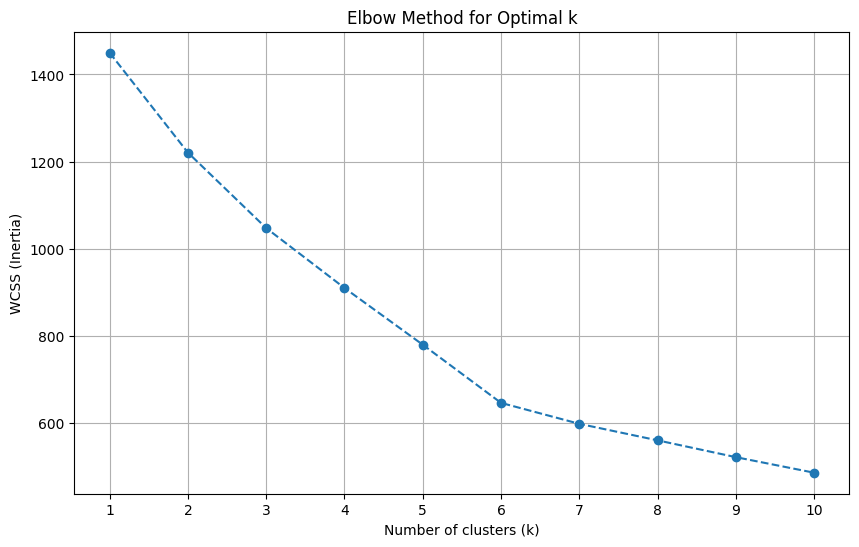

In [2]:
# (โค้ดนี้รันต่อจาก Cell ที่แล้ว โดยใช้ตัวแปร X_scaled)

# --- 4. Elbow Method (หาจำนวนกลุ่มที่เหมาะสม) ---
print("\n--- 4. Finding Optimal 'k' using Elbow Method ---")

# X_scaled คือข้อมูลที่ได้จาก Cell ที่แล้ว

wcss = []  # WCSS = Within-Cluster Sum of Squares
k_range = range(1, 11)  # ทดลอง k ตั้งแต่ 1 ถึง 10

for i in k_range:
    kmeans = KMeans(n_clusters=i, 
                    init='k-means++',  # ใช้วิธีที่ฉลาดในการเลือกจุดเริ่มต้น
                    n_init=10,         # รัน 10 ครั้งด้วยจุดเริ่มต้นต่างกัน
                    random_state=42)   # ล็อคผลลัพธ์ให้เหมือนเดิมทุกครั้ง
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # inertia_ คือค่า WCSS

# --- วาดกราฟ Elbow Method ---
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.xticks(k_range)

# (Optional) บันทึกรูป
# plt.savefig('../reports/figures/04_elbow_method_plot.png')
print("Elbow Method plot generated.")
plt.show()

In [3]:
# (โค้ดนี้รันต่อจาก Cell ที่แล้ว โดยใช้ตัวแปร X_scaled และ df_final)

# --- 5. Run K-Means Clustering & Analyze Results ---
print("\n--- 5. Running K-Means Clustering ---")

# *** ---------------------------------------------------- ***
# *** (สำคัญ) แก้ตัวเลขนี้ตามที่คุณเห็นใน Elbow Plot ***
OPTIMAL_K = 4 
# *** ---------------------------------------------------- ***

print(f"Running K-Means with k={OPTIMAL_K}...")

kmeans = KMeans(n_clusters=OPTIMAL_K, 
                init='k-means++', 
                n_init=10, 
                random_state=42)

# ทำการ fit และ predict พร้อมกัน
cluster_labels = kmeans.fit_predict(X_scaled)

# --- 6. วิเคราะห์ผลลัพธ์ (Analyze Clusters) ---
print("\n--- 6. Analyzing Cluster Results ---")

# 6a. เพิ่ม 'cluster' (ป้ายกลุ่ม) กลับเข้าไปใน DataFrame หลัก
# (ใช้ df_final ที่ยังไม่ได้ scale และ log transform เพื่อให้เราอ่านค่าง่าย)
df_clustered = df_final.copy()
df_clustered['cluster'] = cluster_labels
print("Added 'cluster' labels to the DataFrame.")

# 6b. นับจำนวนเขตในแต่ละกลุ่ม
print("\nDistrict counts per cluster:")
print(df_clustered['cluster'].value_counts().sort_index())

# 6c. วิเคราะห์ "ลักษณะเด่น" ของแต่ละกลุ่ม
# เราจะดูค่า "เฉลี่ย" ของ Feature สำคัญๆ ในแต่ละกลุ่ม
# (เราจะใช้ df_final ที่เราเลือก feature ไว้มาคำนวณ)
analysis_features = [
    'population_density', 
    'rain_max_24h', 
    'rain_days_heavy', 
    'canal_density', 
    'pump_readiness_ratio',
    'คะแนนรวม'
]

# ใช้ .groupby() เพื่อหาค่าเฉลี่ย
cluster_analysis = df_clustered.groupby('cluster')[analysis_features].mean()

print("\n--- Cluster Analysis (Mean values of key features) ---")
print(cluster_analysis)

# --- 7. บันทึกผลลัพธ์ ---
# บันทึกไฟล์ที่มีป้ายกลุ่ม (Cluster Label) แล้ว
clustered_file_path = path_base + "master_features_clustered.csv"
try:
    df_clustered.to_csv(clustered_file_path, index=False)
    print(f"\nSuccessfully saved final clustered data to:\n{clustered_file_path}")
except Exception as e:
    print(f"Error saving file: {e}")

# (Optional) แสดงเขตในกลุ่ม 0
# print("\nDistricts in Cluster 0:")
# print(df_clustered[df_clustered['cluster'] == 0][['dname', 'คะแนนรวม', 'rain_max_24h']])


--- 5. Running K-Means Clustering ---
Running K-Means with k=4...

--- 6. Analyzing Cluster Results ---
Added 'cluster' labels to the DataFrame.

District counts per cluster:
cluster
0     9
1    23
2     9
3     9
Name: count, dtype: int64

--- Cluster Analysis (Mean values of key features) ---
         population_density  rain_max_24h  rain_days_heavy  canal_density  \
cluster                                                                     
0                  0.011710     84.277778         2.444444       0.000001   
1                  0.004170     82.847826         3.478261       0.000001   
2                  0.007523     96.500000         4.666667       0.000002   
3                  0.008785     83.888889         2.888889       0.000004   

         pump_readiness_ratio   คะแนนรวม  
cluster                                   
0                    0.822222  31.222222  
1                    0.820077  22.608696  
2                    0.841358  32.388889  
3                    0.6

In [6]:
import pandas as pd

# --- 1. โหลดไฟล์ผลลัพธ์สุดท้าย ---
print("--- 1. Loading Final Clustered File ---")
path_base = "../data/PROCESSED/"
clustered_file_path = path_base + "master_features_clustered.csv"

try:
    df_report = pd.read_csv(clustered_file_path)
    print(f"Successfully loaded: {clustered_file_path}")
except Exception as e:
    print(f"Error loading file: {e}")

# --- 2. เลือกคอลัมน์สำคัญเพื่อการรายงานผล ---
report_cols = [
    'dname',
    'cluster',
    'คะแนนรวม',
    'rain_max_24h',
    'rain_days_heavy',
    'population_density',
    'canal_density',
    'pump_readiness_ratio'
]

report_cols = [col for col in report_cols if col in df_report.columns]
df_final_report = df_report[report_cols]

# --- 3. แสดงรายชื่อเขตในแต่ละกลุ่ม ---
print("\n--- 3. Final Cluster Report ---")

clusters = sorted(df_final_report['cluster'].unique())

for c in clusters:
    print(f"\n==========================================")
    print(f"Cluster {c} (มี {len(df_final_report[df_final_report['cluster'] == c])} เขต):")
    print(f"==========================================")
    
    districts_in_cluster = df_final_report[df_final_report['cluster'] == c]['dname'].values
    
    for district in districts_in_cluster:
        print(f"- {district}")

# (Optional) แสดงตารางสรุปค่าเฉลี่ยอีกครั้งเพื่อยืนยัน
print("\n--- Summary Analysis (Mean Values) ---")

# ==========================================================
# *** นี่คือบรรทัดที่แก้ไขครับ ***
# เราเพิ่ม (numeric_only=True) เพื่อบอกให้ .mean() 
# คำนวณเฉพาะคอลัมน์ที่เป็นตัวเลข และข้าม 'dname' ไป
print(df_final_report.groupby('cluster').mean(numeric_only=True))
# ==========================================================

--- 1. Loading Final Clustered File ---
Successfully loaded: ../data/PROCESSED/master_features_clustered.csv

--- 3. Final Cluster Report ---

Cluster 0 (มี 9 เขต):
- เขตห้วยขวาง
- เขตวังทองหลาง
- เขตดินแดง
- เขตดุสิต
- เขตพญาไท
- เขตราชเทวี
- เขตพระนคร
- เขตป้อมปราบศัตรูพ่าย
- เขตสัมพันธวงศ์

Cluster 1 (มี 23 เขต):
- เขตลาดกระบัง
- เขตสะพานสูง
- เขตบางแค
- เขตภาษีเจริญ
- เขตประเวศ
- เขตหนองแขม
- เขตราษฏร์บูรณะ
- เขตบางบอน
- เขตบางขุนเทียน
- เขตดอนเมือง
- เขตหนองจอก
- เขตสายไหม
- เขตคลองสามวา
- เขตหลักสี่
- เขตบางเขน
- เขตจตุจักร
- เขตคันนายาว
- เขตมีนบุรี
- เขตลาดพร้าว
- เขตบางซื่อ
- เขตบึงกุ่ม
- เขตบางกะปิ
- เขตทุ่งครุ

Cluster 2 (มี 9 เขต):
- เขตปทุมวัน
- เขตสวนหลวง
- เขตวัฒนา
- เขตคลองเตย
- เขตบางรัก
- เขตสาทร
- เขตยานนาวา
- เขตพระโขนง
- เขตบางนา

Cluster 3 (มี 9 เขต):
- เขตบางพลัด
- เขตทวีวัฒนา
- เขตตลิ่งชัน
- เขตบางกอกน้อย
- เขตบางกอกใหญ่
- เขตธนบุรี
- เขตคลองสาน
- เขตจอมทอง
- เขตบางคอแหลม

--- Summary Analysis (Mean Values) ---
          คะแนนรวม  rain_max_24h  rain_days_heavy  